<center><h1 style="font-size:2.5vw"> AML Project 1 </h1></center>

---
<div style="display:flex; flex-direction:row; width:35%; justify-content : space-between">
    <div style = "display : flex, flex-direction : column">
        <div><b><font color = "#3285d3">Authors</font></b></div>
        <div><b><font color = "#3285d3">Date</font></b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div>Albert Roathel, Marcel Affi</div>
        <div>April 2021</div>
    </div>
</div>

# Project outline

1. [Preprocessing Datasets](#Preprocessing_Datasets)
2. [Measures of Classification](#measures_of_classification)
3. [Optimization Algorithms](#optimization_algorithms)
4. [Experiments](#experiments)

<a id='Preprocessing_Datasets'></a>
## Preprocessing Datasets

We chose to work with the following datasets, each consisting of binary class variables : 
* Titanic
* Students

TODO: ADD MORE DATASETS

### Downloading the datasets

In [97]:
%%capture --no-stderr

# Students.csv
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
!unzip -o student.zip

# Titanic.csv
!curl -O -k https://www.openml.org/data/get_csv/16826755/phpMYEkMl
!mv phpMYEkMl titanic.csv

### Importing libraries

In [133]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Seaborn properties
sns.set(rc={'figure.figsize':(11.7,5), 'figure.dpi':200})

# plotty properties
def show_plot(fig):
    fig.update_layout({
        'plot_bgcolor': 'rgba(10, 10, 10, 0.1)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'xaxis': {
            'showgrid': False,
            'showline': False,
        },
        'yaxis': {
            'showgrid': False,
            'showline': False,
        }
    })
    fig.show()

# Ignore numpy overflow warnings in sigmoid function
np.seterr( over='ignore' );

In [99]:
titanic = pd.read_csv('titanic.csv')
titanic.cabin = titanic.cabin.str[0].value_counts()
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,NaN,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,NaN,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,NaN,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,NaN,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,NaN,S,?,?,"Montreal, PQ / Chesterville, ON"


In [100]:
for column in titanic.columns:
    missing = (titanic[column] == '?').mean()
    if missing > 0:
        print(column, missing)
        titanic.loc[titanic[column] == '?', column] = None

age 0.20091673032849502
fare 0.0007639419404125286
embarked 0.0015278838808250573
boat 0.6287242169595111
body 0.907563025210084
home.dest 0.43086325439266615


boat and body will be omitted as most of observations do not have this value; home.dest and boat has too many potential values 

In [101]:
mask = titanic[['age', 'fare']].isna().apply(any, axis=1)
titanic = titanic.loc[~mask]

In [102]:
def onehotencoding(series):
    N = len(series)
    levels = series.unique()
    data = np.zeros([N, len(levels)])
    for i, level in enumerate(levels):
        data[series == level, i] = 1
    return data

<a id='measures_of_classification'></a>
## Measures of classification

In [103]:
def calculate_scores(y_true, y_pred):
    unique_classes = np.unique(y_true)
    conf_matrix = np.zeros([len(unique_classes), len(unique_classes)])
    conf_matrix[0, 0] = np.sum(y_pred[y_true==0] == 0)
    conf_matrix[1, 1] = np.sum(y_pred[y_true==1] == 1)
    conf_matrix[0, 1] = np.sum(y_pred[y_true==0] == 1)
    conf_matrix[1, 0] = np.sum(y_pred[y_true==1] == 0)
    
    acc = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    conf_matrix = pd.DataFrame(conf_matrix, columns=["0", "1"])
    return conf_matrix, acc

<a id='optimization_algorithms'></a>
## Optimization Algorithms

In [104]:
# sigmoid function; models the probability in logistic regression
def sigmoid(X, beta):
    exp = np.exp(np.dot(X, -beta))
    return 1 / (1 + exp)

In [105]:
# cost function for log likelihood optimization
def cost_function(X, y, beta):
    return np.dot(X.T, (y - sigmoid(X, beta)))

In [106]:
# gradient descent approach for minimazation
def gradient_descent(X, y, n_iter=1000, l_rate=1e-4):
    N, p = X.shape
    # initial betas
    beta = np.random.randn(p)
    
    for i in range(n_iter):
        cost = cost_function(X, y, beta)
        beta += cost * l_rate
        
    return beta

In [107]:
def SGD(X, y, n_iter=1000, l_rate=1e-4, n_chunk=50):
    N, p = X.shape
    # initial betas
    beta = np.random.randn(p)
    
    for _ in range(n_iter):
        ind = np.arange(N)
        np.random.shuffle(ind)
        for i in range(0, N, n_chunk):
            subset = ind[i:min(i + n_chunk, N) + 1]
            cost = cost_function(X, y, beta)
            update = cost * l_rate
            beta += update
        
    return beta

In [108]:
# TODO : adjust for intercept
def IRLS(X, y, n_iter=1000, w_init = 1, d = 0.5, tolerance = 0.001):
    n,p = X.shape
    delta = np.array(np.repeat(d, n)).reshape(1,n)
    w = np.repeat(1, n)
    W = np.diag( w )
    B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
     ( X.T.dot(W).dot(y) ) )
    for _ in range(n_iter):
        _B = B
        _w = abs(y - X.dot(B)).T
        w = float(1)/np.maximum( delta, _w )
        W = np.diag( w[0] )
        B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
         ( X.T.dot(W).dot(y) ) )
        tol = np.sum( abs( B - _B ) ) 
        if tol < tolerance:
            return B
    return B

<a id='experiments'></a>
## Experiments

In [130]:
data = []
# I removed some of the variables that seemed unnecessary

#for column in ['pclass', 'sex', 'sibsp', 'parch']:
for column in ['pclass', 'sex', 'parch']:
    data.append(onehotencoding(titanic[column]))
#for column in ['age', 'fare']:
for column in ['age']:
    data.append(titanic[column].values.astype(float).reshape([len(titanic), 1]))

X = np.concatenate(data, axis=1)
y = titanic.survived.values

In [110]:
titanic_plot = titanic.copy()
categories = ['pclass','sex',
              'parch', 'fare']

#titanic_plot.age = titanic.age.astype(float).astype(int)
titanic_plot.fare = titanic.fare.astype(float)
titanic_plot.pclass = titanic.pclass * 20
titanic_plot.parch = titanic.parch * 100
#titanic_plot.sibsp = titanic.sibsp * 100
titanic_plot.sex = titanic.sex.apply(lambda sex : 0 if sex == "female" else 100)
surviveded_mean_vals = titanic_plot.loc[titanic_plot['survived'] == 1][categories].mean().values.tolist()
not_survived_mean_vals = titanic_plot.loc[titanic_plot['survived'] == 0][categories].mean().values.tolist()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=surviveded_mean_vals,
      theta=categories,
      fill='toself',
      name='Survived'
))
fig.add_trace(go.Scatterpolar(
      r=not_survived_mean_vals,
      theta=categories,
      fill='toself',
      name='Not Survived'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=False
)

fig.show()

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [119]:
np.random.seed(500)

beta = gradient_descent(X_train, y_train, l_rate=1e-4)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 72.93%


,0,1
0,137.0,38.0
1,47.0,92.0


In [120]:
np.random.seed(500)

beta = SGD(X_train, y_train, l_rate=1e-4)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 73.57%


,0,1
0,139.0,36.0
1,47.0,92.0


In [121]:
beta = IRLS(X_train, y_train, d=0.01)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 46.82%


,0,1
0,84.0,91.0
1,76.0,63.0


In [126]:
def performance_over_iterations(X, y, iterations : int, opt_method):
    beta = opt_method(X, y, n_iter = iterations)
    pred = (sigmoid(X_test, beta) > 0.5).astype(int)
    _, acc = calculate_scores(y_test, pred)
    return [iterations,acc]

from_iter, to_iter, step_size = 20, 1020, 10

  0%|          | 0/100 [00:00<?, ?it/s]

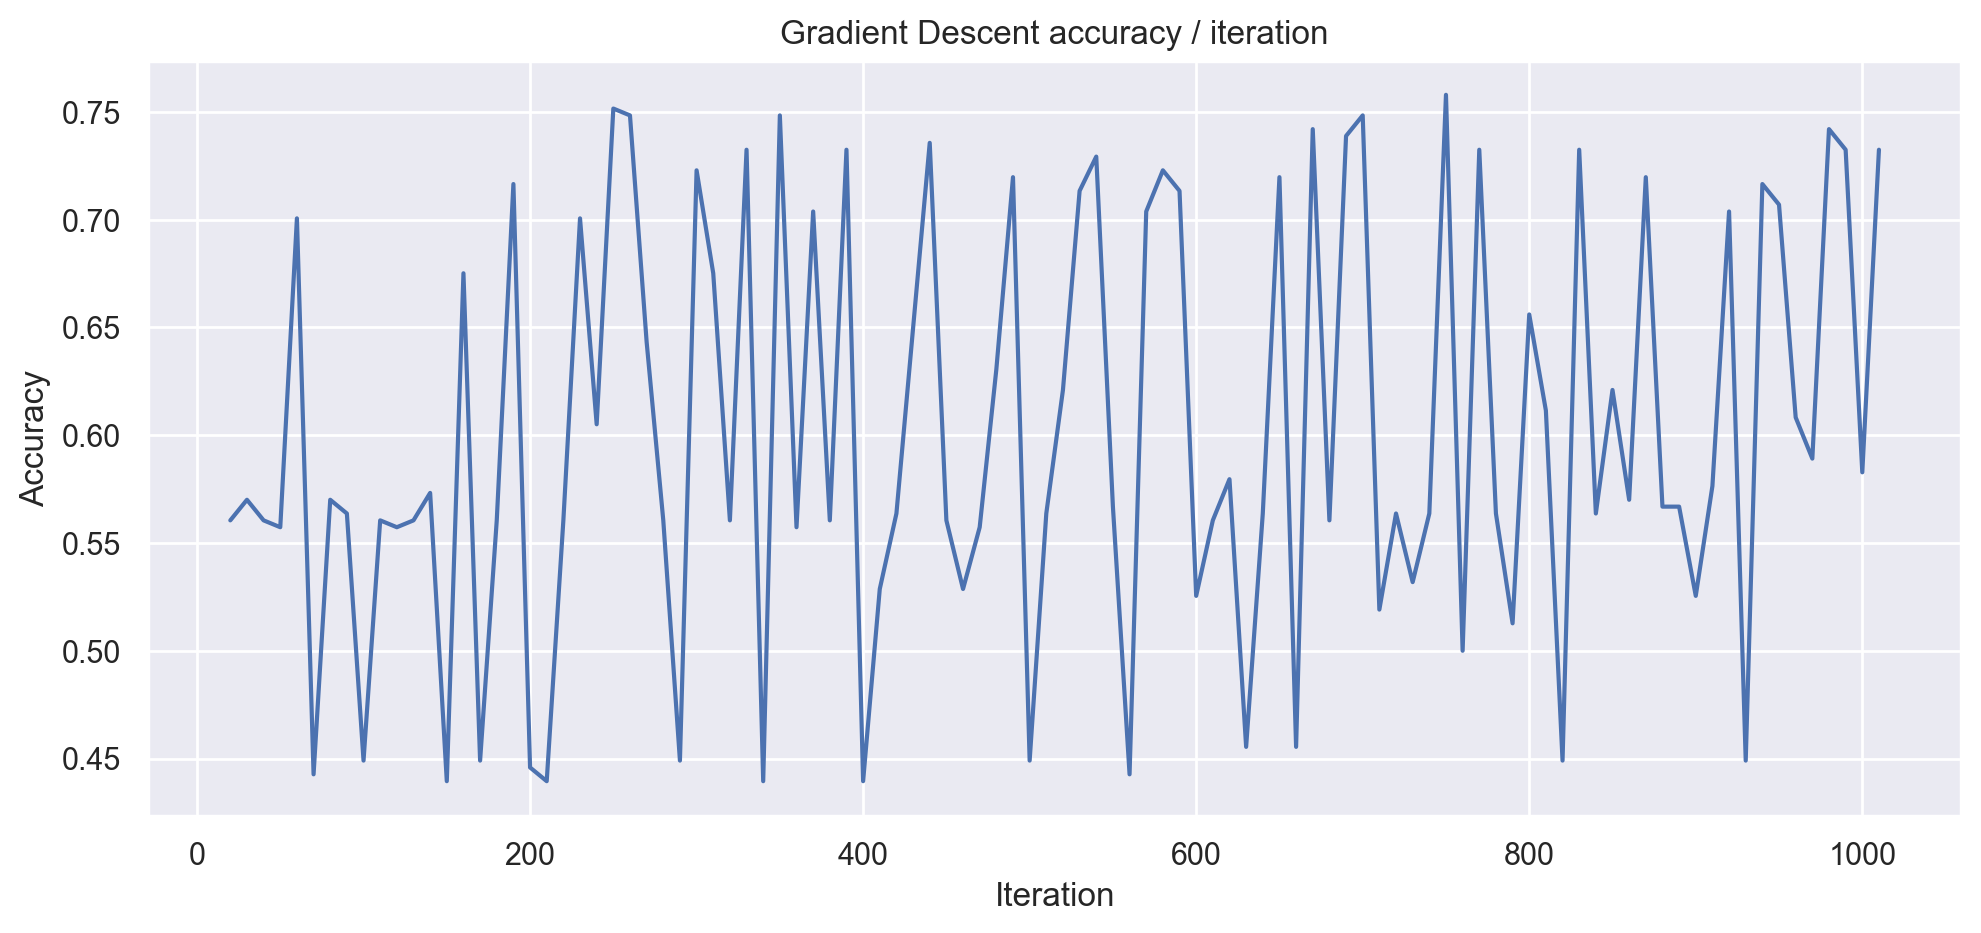

In [127]:
np.random.seed(500)

gd_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, gradient_descent) for iters in tqdm(range(from_iter, to_iter, step_size))]
gd_iter_acc = pd.DataFrame (gd_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= gd_iter_acc, x = "Iteration", y = "Accuracy").set_title("Gradient Descent accuracy / iteration")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

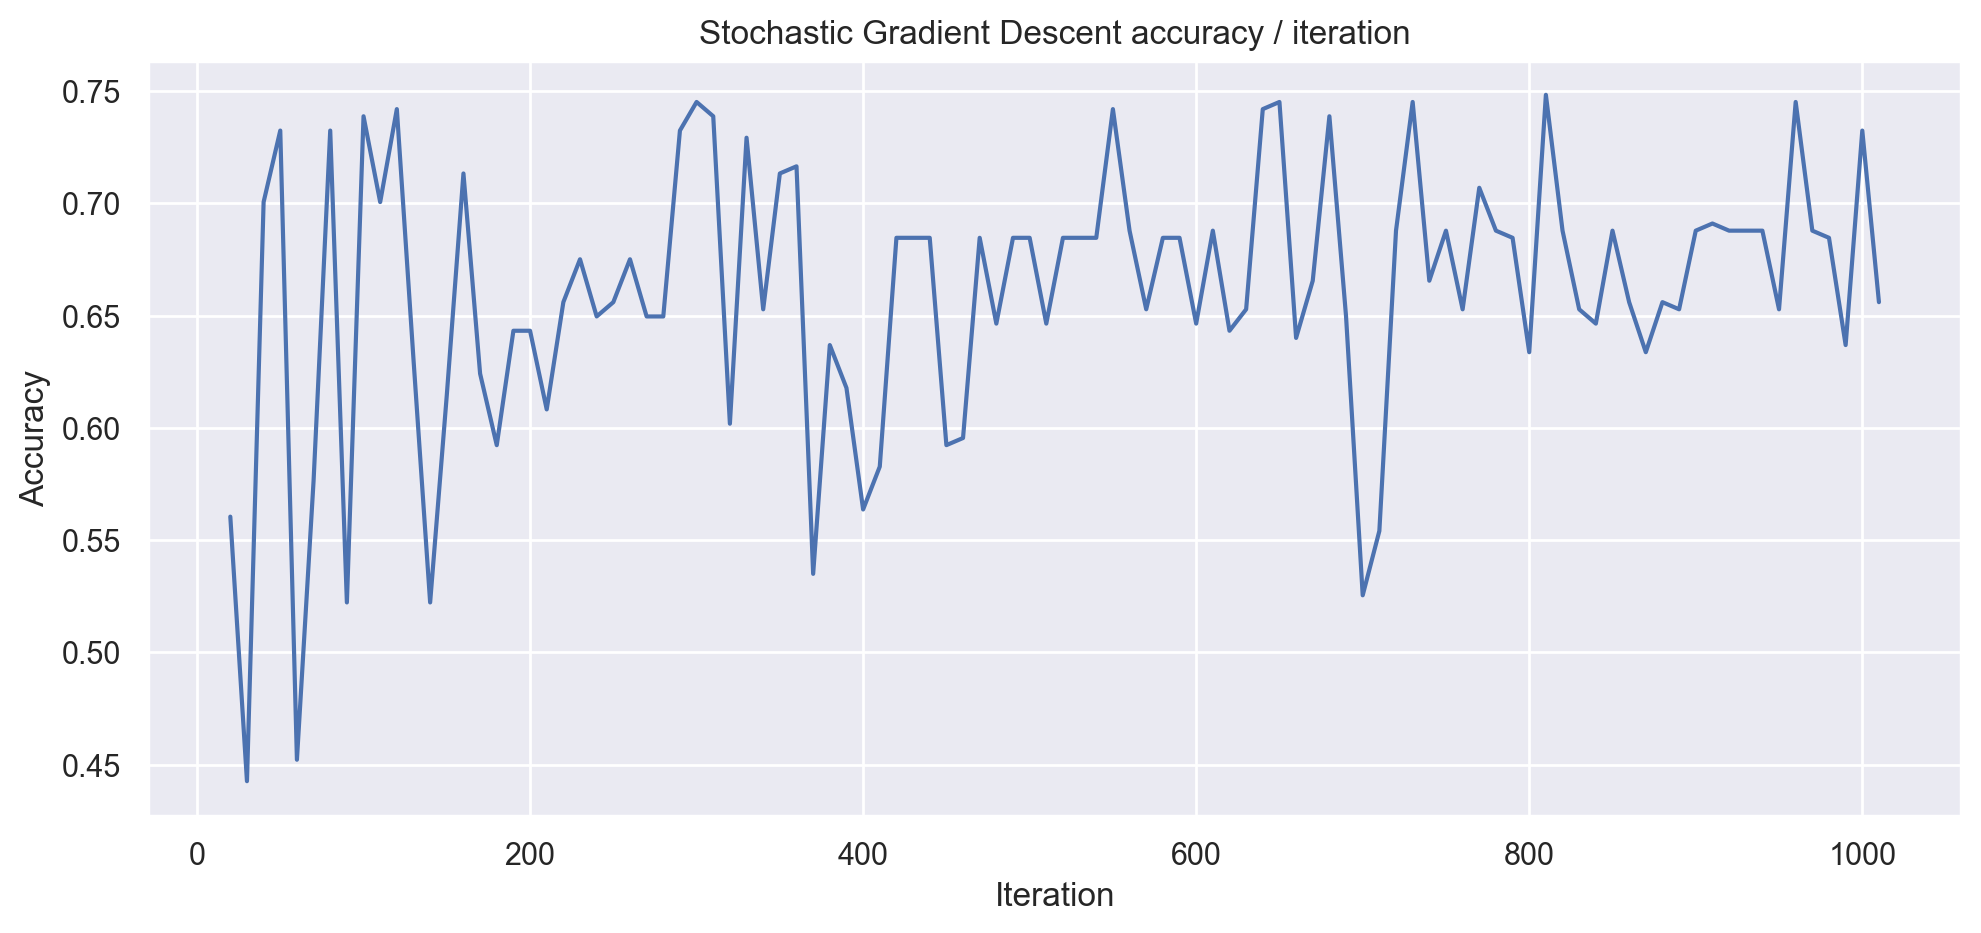

In [128]:
np.random.seed(500)

sgd_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, SGD) for iters in tqdm(range(from_iter, to_iter, step_size))]
sgd_iter_acc = pd.DataFrame (sgd_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= sgd_iter_acc, x = "Iteration", y = "Accuracy").set_title("Stochastic Gradient Descent accuracy / iteration")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

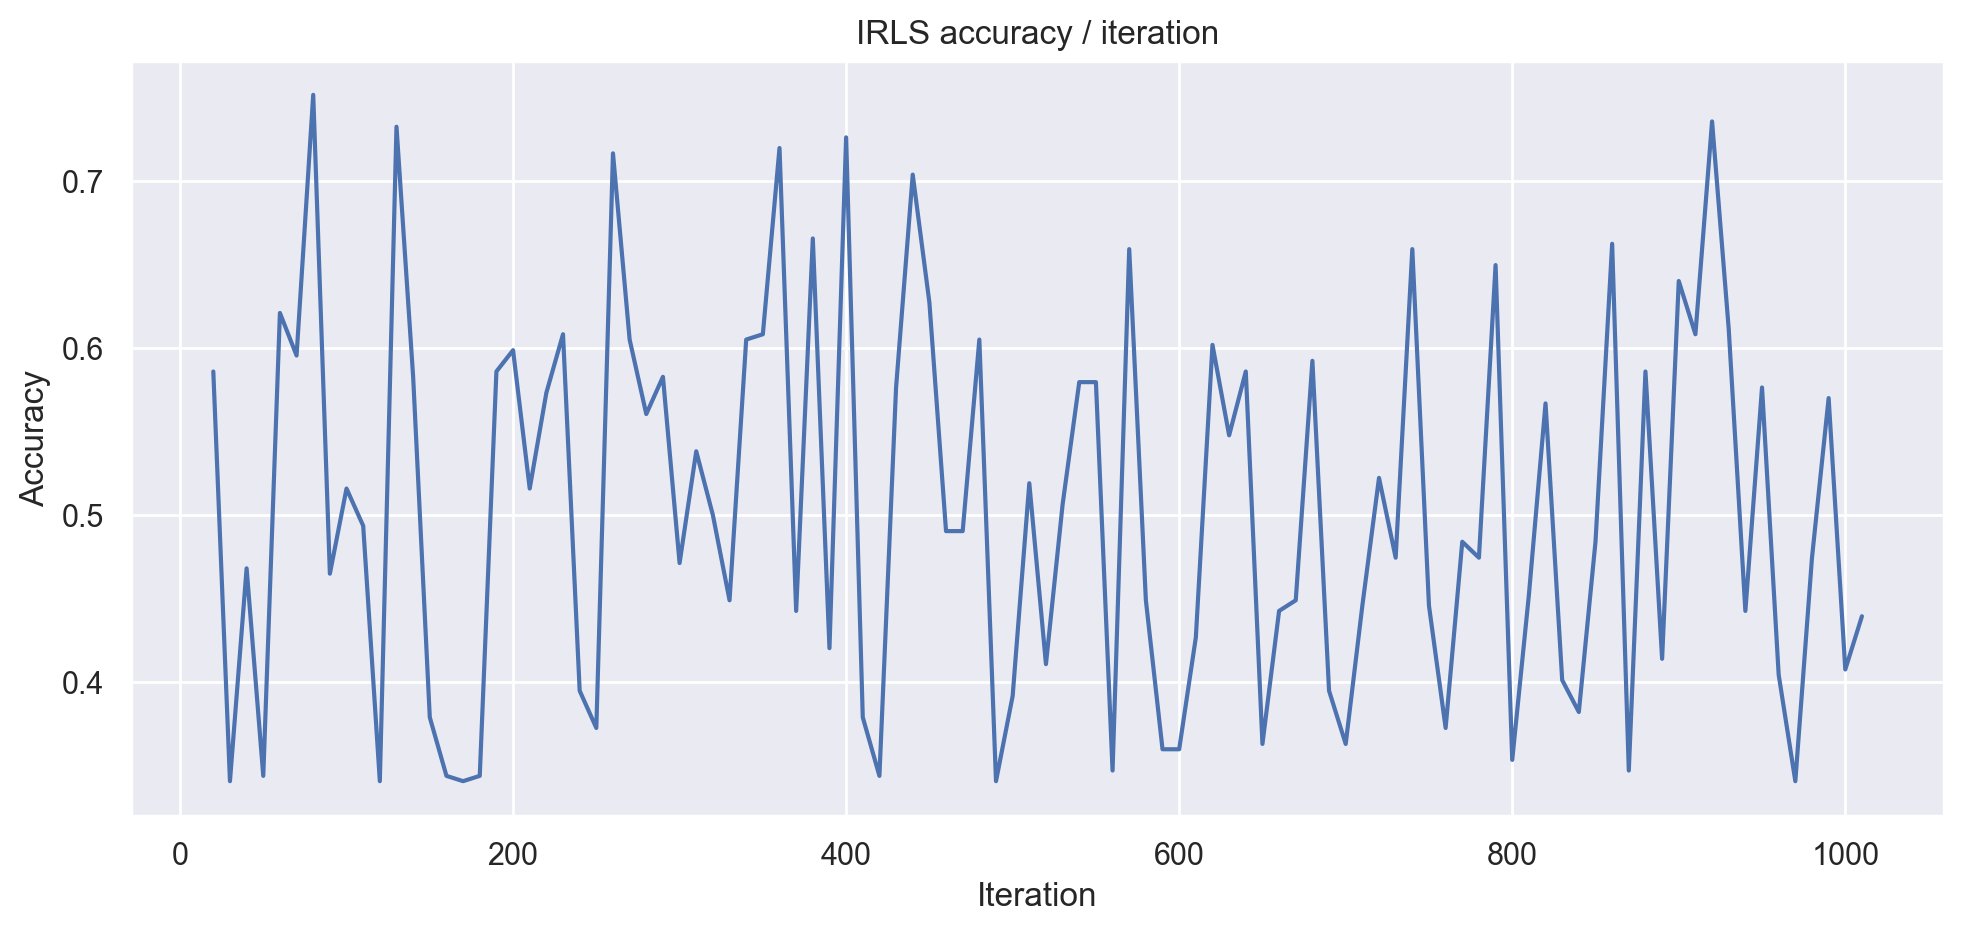

In [129]:
irls_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, IRLS) for iters in tqdm(range(from_iter, to_iter, step_size))]
irls_iter_acc = pd.DataFrame (irls_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= irls_iter_acc, x = "Iteration", y = "Accuracy").set_title("IRLS accuracy / iteration")
plt.show()

### Testing against other methods form mentioned libraries

Logistic Regression from sklearn

In [105]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

# This actually means that our SGD did a good job (73%)

0.7452229299363057

KNeighborsClassifier from sklearn

In [134]:
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
nca_pipe.score(X_test, y_test)

0.7165605095541401

LDA ftom sklearn

In [142]:
clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7356687898089171

QDA from sklearn

In [148]:
clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:715: UserWarning:

Variables are collinear

/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:740: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:743: RuntimeWarning:

divide by zero encountered in log



0.4426751592356688

### Mock data for testing

In [61]:
# lets create simple dataset consiting of N point in R2 that can belong to 2 classes
N = 1000
X = np.random.randn(N * 2).reshape(N, 2) - 1
X[:N//2] = X[:N//2] + 2
y = np.array([0] * (N//2) + [1] * (N//2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y)
show_plot(fig)

In [642]:
# add column of ones to include intercept in the model
intercept = np.ones((X.shape[0], 1))
X = np.concatenate((intercept, X), axis = 1)

In [25]:
beta = gradient_descent(X, y, l_rate=1e-4)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.30%


,0,1
0,456.0,44.0
1,53.0,447.0


In [26]:
beta = SGD(X, y, l_rate=1e-4)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.30%


,0,1
0,456.0,44.0
1,53.0,447.0


In [27]:
# This is low because IRLS is fucking up with the added intercept column, if you remove the intercept
# works as intended, I'll need to check on that maybe tomorrow
beta = IRLS(X, y, n_iter=1000, w_init = 1, d=0.5)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.40%


,0,1
0,456.0,44.0
1,52.0,448.0


In [646]:
xx = np.linspace(-5, 5, 100)
yy = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(xx, yy)
xx, yy = xx.flatten(), yy.flatten()
mock_data = np.array([np.ones(len(xx)), xx, yy]).T
values = sigmoid(mock_data, beta)
go.Figure(
    [
        go.Contour(x=xx, y=yy, z=values),
        go.Scatter(x=X[y==0, 1], y=X[y==0, 2], mode='markers', marker_color='red'),
        go.Scatter(x=X[y==1, 1], y=X[y==1, 2], mode='markers', marker_color='blue')
    ],
    layout=dict(
        xaxis=dict(scaleanchor='y', scaleratio=1),
        width=600, height=600,
        showlegend=False
    )
)